In [1]:
!pip install pandas scikit-learn matplotlib --upgrade xgboost --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from ipaddress import ip_address
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [16]:
print("Upload do arquivo 'train_test_network.csv'")
df = pd.read_csv('train_test_network.csv')

Upload do arquivo 'train_test_network.csv'


In [17]:
def is_internal_ip(ip_str):
    if not isinstance(ip_str, str):
        return False
    try:
        return ip_address(ip_str).is_private
    except ValueError:
        return False
df['src_is_internal'] = df['src_ip'].apply(is_internal_ip).astype(int)
df['dst_is_internal'] = df['dst_ip'].apply(is_internal_ip).astype(int)

Separaçãp de Caracteristicas (x) e Alvo (y)

In [18]:
try:
    X = df.drop(columns=['label', 'type', 'src_ip', 'dst_ip'])
    y = df['label'].astype(int)
except KeyError as e:
    print(f"Erro ao definir X e y: Coluna não encontrada - {e}")
    raise

Divisao de treino e teste

In [19]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=None, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=None, stratify=y_temp
)

print(" Dados divididos em Treino e Teste ")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_val:   {X_val.shape}")
print(f"Formato de X_test: {X_test.shape}\n")

print(" Verificando os índices dos dados de treino ") #verificando se o random state none esta funcionando
print(X_train.index[:5])

 Dados divididos em Treino e Teste 
Formato de X_train: (126625, 42)
Formato de X_val:   (42209, 42)
Formato de X_test: (42209, 42)

 Verificando os índices dos dados de treino 
Index([20393, 133760, 101280, 20103, 122282], dtype='int64')


One-hot encoding, imputação de valores ausentes, normalização e remoção de caracteres especiais

In [20]:
# One-Hot Encoding para colunas categóricas
print("Convertendo colunas 'string' para formato numérico")
categorical_columns = X_train.select_dtypes(include=['object']).columns
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True, dtype=int)
X_val = pd.get_dummies(X_val, columns=categorical_columns, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True, dtype=int)

print("Alinhando colunas entre os conjuntos de treino e teste")
all_cols = X_train.columns.union(X_val.columns).union(X_test.columns)

X_train = X_train.reindex(columns=all_cols, fill_value=0)
X_val = X_val.reindex(columns=all_cols, fill_value=0)
X_test = X_test.reindex(columns=all_cols, fill_value=0)



# Imputação de valores ausentes
print("Preenchendo valores ausentes com a média do treino")
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=all_cols)
X_val = pd.DataFrame(imputer.transform(X_val), columns=all_cols) 
X_test = pd.DataFrame(imputer.transform(X_test), columns=all_cols) 



# Normalização (Scaling)
print("Normalizando características com base nos dados de treino")
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=all_cols)
X_val = pd.DataFrame(scaler.transform(X_val), columns=all_cols) 
X_test = pd.DataFrame(scaler.transform(X_test), columns=all_cols) 


# Remoção de caracteres especiais dos nomes das colunas
print("Removendo caracteres especiais dos nomes das colunas\n")
X_train.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_train.columns]
X_val.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_val.columns]
X_test.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_test.columns]

print(" Pré-processamento concluído com sucesso! ")

Convertendo colunas 'string' para formato numérico
Alinhando colunas entre os conjuntos de treino e teste
Preenchendo valores ausentes com a média do treino
Normalizando características com base nos dados de treino
Removendo caracteres especiais dos nomes das colunas

 Pré-processamento concluído com sucesso! 


PCA


In [14]:
pca = PCA(n_components=0.95)

# Aprende a transformação PCA APENAS com os dados de treino
pca.fit(X_train)

# Aplica a transformação nos três conjuntos de dados
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Número original de features: {X_train.shape[1]}")
print(f"Número de features após o PCA: {pca.n_components_}\n")

# --- 6. TREINAMENTO E AVALIAÇÃO DO MODELO COM DADOS DO PCA ---
print("--- Treinando modelo com dados reduzidos pelo PCA ---")
xgboost_pca = XGBClassifier(random_state=42)
xgboost_pca.fit(X_train_pca, y_train)

# Avaliação final no conjunto de teste transformado pelo PCA
y_pred_pca = xgboost_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f"\nAcurácia Final do Modelo com PCA: {accuracy_pca:.4f}\n")
print("Relatório de Classificação (PCA):")
print(classification_report(y_test, y_pred_pca))

Número original de features: 951
Número de features após o PCA: 708

--- Treinando modelo com dados reduzidos pelo PCA ---

Acurácia Final do Modelo com PCA: 0.9987

Relatório de Classificação (PCA):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     32209

    accuracy                           1.00     42209
   macro avg       1.00      1.00      1.00     42209
weighted avg       1.00      1.00      1.00     42209



LDA


In [22]:
print("--- Aplicando LDA ---")
# Para classificação binária, o LDA sempre resultará em 1 componente.
lda = LinearDiscriminantAnalysis()

# Aprende a transformação LDA usando os dados de treino E OS RÓTULOS (y_train)
lda.fit(X_train, y_train)

# Aplica a transformação nos três conjuntos de dados
X_train_lda = lda.transform(X_train)
X_val_lda = lda.transform(X_val)
X_test_lda = lda.transform(X_test)

print(f"Número original de features: {X_train.shape[1]}")
print(f"Número de features após o LDA: {X_train_lda.shape[1]}\n")

# --- 6. TREINAMENTO E AVALIAÇÃO DO MODELO COM DADOS DO LDA ---
print("--- Treinando modelo com dados reduzidos pelo LDA ---")
xgboost_lda = XGBClassifier(random_state=42)
xgboost_lda.fit(X_train_lda, y_train)

# Avaliação final no conjunto de teste transformado pelo LDA
y_pred_lda = xgboost_lda.predict(X_test_lda)
accuracy_lda = accuracy_score(y_test, y_pred_lda)

print(f"\nAcurácia Final do Modelo com LDA: {accuracy_lda:.4f}\n")
print("Relatório de Classificação (LDA):")
print(classification_report(y_test, y_pred_lda))

--- Aplicando LDA ---
Número original de features: 951
Número de features após o LDA: 1

--- Treinando modelo com dados reduzidos pelo LDA ---

Acurácia Final do Modelo com LDA: 0.9865

Relatório de Classificação (LDA):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10000
           1       1.00      0.99      0.99     32209

    accuracy                           0.99     42209
   macro avg       0.98      0.99      0.98     42209
weighted avg       0.99      0.99      0.99     42209



Treinamento do modelo XgBoost

In [23]:
print("\nTreinando o modelo XGBoost")
xgb_model = XGBClassifier(eval_metric='logloss', random_state=None)
xgb_model.fit(X_train, y_train)
y = df['label'].astype(int)
print("Treinamento concluído.")


Treinando o modelo XGBoost
Treinamento concluído.


Avaliaçao no cojunto de teste

 Avaliação do Modelo no Conjunto de TESTE 
Acurácia Final do Modelo no Conjunto de Teste: 0.9995

Relatório de Classificação Final:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     32209

    accuracy                           1.00     42209
   macro avg       1.00      1.00      1.00     42209
weighted avg       1.00      1.00      1.00     42209

Matriz de Confusão Final:


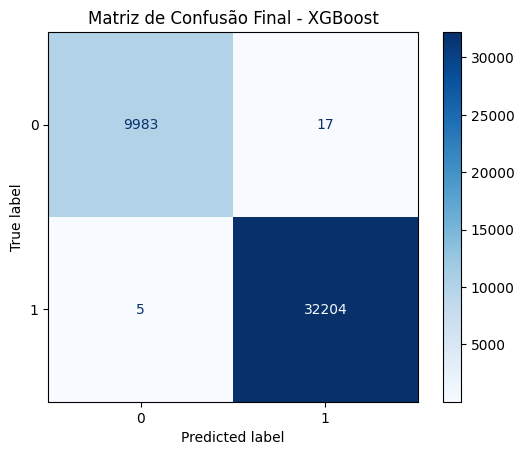

In [24]:
print(" Avaliação do Modelo no Conjunto de TESTE ")
y_pred_test = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)

print(f"Acurácia Final do Modelo no Conjunto de Teste: {accuracy:.4f}\n")
print("Relatório de Classificação Final:")
print(classification_report(y_test, y_pred_test))

print("Matriz de Confusão Final:")
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão Final - XGBoost")
plt.show()

Teste com dados de validação

In [ ]:
print("Treinando modelo com max_depth=3")
xgb_model_d3 = XGBClassifier(eval_metric='logloss', random_state=None, max_depth=3)
xgb_model_d3.fit(X_train, y_train)

y_pred_val_d3 = xgb_model_d3.predict(X_val)
acc_d3 = accuracy_score(y_val, y_pred_val_d3)
print(f"Acurácia na VALIDAÇÃO (max_depth=3): {acc_d3:.4f}\n")
print("Treinando modelo com max_depth=5")
xgb_model_d5 = XGBClassifier(eval_metric='logloss', random_state=42, max_depth=5)
xgb_model_d5.fit(X_train, y_train)

y_pred_val_d5 = xgb_model_d5.predict(X_val)
acc_d5 = accuracy_score(y_val, y_pred_val_d5)
print(f"Acurácia na VALIDAÇÃO (max_depth=5): {acc_d5:.4f}\n")

if acc_d5 > acc_d3:
    print("O modelo com max_depth=5 se saiu melhor")
    best_model = xgb_model_d5
else:
    print("O modelo com max_depth=3 se saiu melhor")
    best_model = xgb_model_d3

Treinando modelo com max_depth=3...
Acurácia na VALIDAÇÃO (max_depth=3): 0.9988

Treinando modelo com max_depth=5...
Acurácia na VALIDAÇÃO (max_depth=5): 0.9994

O modelo com max_depth=5 se saiu melhor


In [ ]:
xgb_model_early = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_estimators=1000 # Aumentamos o número de árvores, pois ele vai parar antes
)

print("Treinando modelo com Parada Antecipada")

# O 'eval_set' diz ao modelo para usar os dados de validação como "simulado"
xgb_model_early.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
     verbose=False            
)

print("Treinamento concluído com Parada Antecipada!")
y_pred_final = xgb_model_early.predict(X_test)
acc_final = accuracy_score(y_test, y_pred_final)

print(f"\nAcurácia do modelo no conjunto de TESTE: {acc_final:.4f}")
print(classification_report(y_test, y_pred_final))

Treinando modelo com Parada Antecipada...
Treinamento concluído com Parada Antecipada!

Acurácia do modelo com Early Stopping no conjunto de TESTE: 0.9990
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     32209

    accuracy                           1.00     42209
   macro avg       1.00      1.00      1.00     42209
weighted avg       1.00      1.00      1.00     42209



Analise caracteristicas mais importantes


--- Análise da Importância das Características ---
Top 15 características mais importantes:
1. proto_tcp — importância: 0.2867
2. dns_rejected_T — importância: 0.2104
3. proto_udp — importância: 0.1600
4. dns_RA_T — importância: 0.1161
5. src_pkts — importância: 0.0467
6. ssl_resumed_F — importância: 0.0319
7. weird_notice_F — importância: 0.0179
8. dst_ip_bytes — importância: 0.0150
9. dst_port — importância: 0.0138
10. src_ip_bytes — importância: 0.0103
11. dns_qclass — importância: 0.0070
12. ssl_established_T — importância: 0.0068
13. dst_is_internal — importância: 0.0068
14. dns_query_1921681195dvwaloginphprhub — importância: 0.0053
15. http_status_code — importância: 0.0051


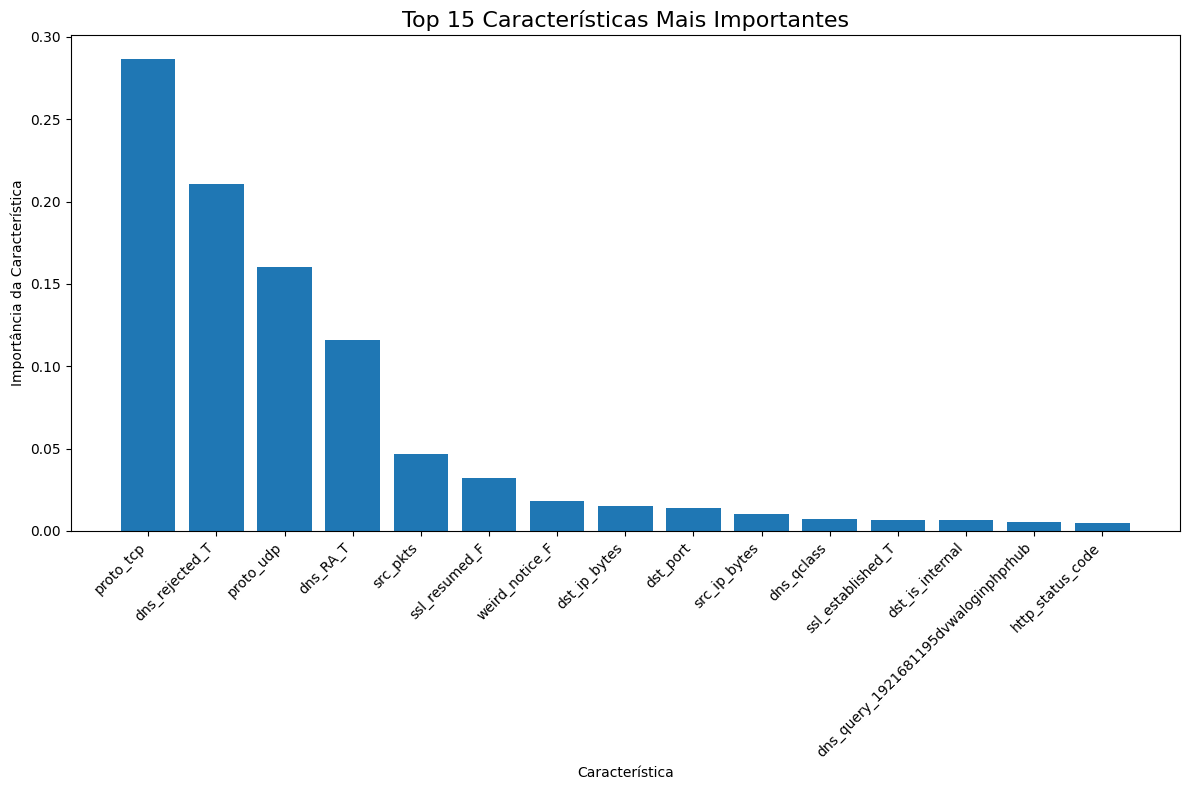

In [ ]:
print("\n Análise da Importância das Características ")
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15
top_features_list = X_train.columns[indices[:top_n]]

print(f"Top {top_n} características mais importantes:")
for i, feature in enumerate(top_features_list):
    print(f"{i+1}. {feature} — importância: {importances[indices[i]]:.4f}")

# Gráfico de importância
plt.figure(figsize=(12, 8))
plt.title(f"Top {top_n} Características Mais Importantes", fontsize=16)
plt.bar(range(top_n), importances[indices][:top_n], align='center')
plt.xticks(range(top_n), top_features_list, rotation=45, ha='right')
plt.ylabel("Importância da Característica")
plt.xlabel("Característica")
plt.tight_layout()
plt.show()